In [1]:
!nvidia-smi

Sat May 21 07:30:23 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0 Off |                  N/A |
|  0%   41C    P8    21W / 370W |      1MiB / 24576MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install torchmetrics

In [3]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
import albumentations as A
import torchvision
import torchvision.transforms as transforms
import albumentations.pytorch
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
import cv2
from tqdm import tqdm
from torchmetrics.functional import jaccard_index

In [4]:
torch.__version__

'1.11.0+cu113'

## Data

In [7]:
label_path = "./PH2Dataset/clinical_diagnosis_labels.csv"
df = pd.read_csv(label_path)
subject_list = list(df["Name"])

In [8]:
def train_valid_test_split(folder, train_ratio, valid_ratio, test_ratio):
    
    normal_nevus = 0
    atypical_nevus = 0
    melanoma = 0
    
    train_files=[]
    valid_files=[]
    test_files=[]
    
    for file in folder:
        if normal_nevus <= 80:  
            if normal_nevus < 80*train_ratio:
                train_files.append(file)
            elif normal_nevus < 80*(train_ratio+valid_ratio):
                valid_files.append(file)
            else:
                test_files.append(file)
            normal_nevus += 1
            
        elif atypical_nevus <= 80:
            if atypical_nevus < 80*train_ratio:
                train_files.append(file)
            elif atypical_nevus < 80*(train_ratio+valid_ratio):
                valid_files.append(file)
            else:
                test_files.append(file)
            atypical_nevus += 1
        
        else:
            if melanoma < 40*train_ratio:
                train_files.append(file)
            elif melanoma < 40*(train_ratio+valid_ratio):
                valid_files.append(file)
            else:
                test_files.append(file)
            melanoma += 1
            
    return train_files, valid_files, test_files

In [9]:
config = {
    "model": "frcn",
    "image_height": 192,
    "image_width": 256,
    "initial_lr": 1e-4,
    "n_epochs": 40,
    "batch_size": 1
}

In [10]:
train_files, valid_files, test_files = train_valid_test_split(subject_list, 0.8, 0.1, 0.1)

In [11]:
print(len(train_files), len(valid_files), len(test_files))

160 20 20


In [12]:
normal_nevus = 0
atypical_nevus = 0
melanoma = 0
for file in train_files:
    label = df.loc[df['Name']==file,['Clinical Diagnosis']]
    if (label == 0).bool():
        normal_nevus += 1
    elif (label == 1).bool():
        atypical_nevus += 1
    else:
        melanoma += 1
print(normal_nevus, atypical_nevus, melanoma)

64 64 32


In [13]:
normal_nevus = 0
atypical_nevus = 0
melanoma = 0
for file in valid_files:
    label = df.loc[df['Name']==file,['Clinical Diagnosis']]
    if (label == 0).bool():
        normal_nevus += 1
    elif (label == 1).bool():
        atypical_nevus += 1
    else:
        melanoma += 1
print(normal_nevus, atypical_nevus, melanoma)

8 8 4


In [14]:
normal_nevus = 0
atypical_nevus = 0
melanoma = 0
for file in test_files:
    label = df.loc[df['Name']==file,['Clinical Diagnosis']]
    if (label == 0).bool():
        normal_nevus += 1
    elif (label == 1).bool():
        atypical_nevus += 1
    else:
        melanoma += 1
print(normal_nevus, atypical_nevus, melanoma)

8 8 4


In [15]:
train_tfm = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((config["image_height"], config["image_width"])),
    transforms.ToTensor()
])

test_tfm = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((config["image_height"], config["image_width"])),
    transforms.ToTensor()
])

In [16]:
class PH2Dataset(Dataset):
    def __init__(self, file_list, transforms):
      
        self.dataset_path = "./PH2Dataset/PH2 Dataset images/"
        self.subject_list = file_list
        self.transforms = transforms
    
    def __len__(self):
       
        return len(self.subject_list)

    def __getitem__(self, idx):
        
        subject = self.subject_list[idx]
        
        img_folder = subject + "_Dermoscopic_Image"
        img_filename = subject + ".bmp"
        mask_folder =  subject + "_lesion"
        mask_filename =  mask_folder + ".bmp"
        
        image_path = os.path.join(self.dataset_path, subject, img_folder, img_filename)
        mask_path = os.path.join(self.dataset_path, subject, mask_folder, mask_filename)
        
        # load the image from disk, swap its channels from BGR to RGB,
        # and read the associated mask from disk in grayscale mode
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path,0)
        
        
        if self.transforms is not None:
            image = self.transforms(image)
            mask = self.transforms(mask)
            
        return image, mask

In [17]:
train_set = PH2Dataset(train_files, transforms=train_tfm)
valid_set = PH2Dataset(valid_files, transforms=test_tfm)
test_set = PH2Dataset(test_files, transforms=test_tfm)

torch.Size([192, 256, 3])
tensor([[[0.3608, 0.3255, 0.3373],
         [0.3608, 0.3255, 0.3412],
         [0.3608, 0.3216, 0.3412],
         ...,
         [0.3412, 0.3098, 0.3176],
         [0.3412, 0.3098, 0.3176],
         [0.3333, 0.3137, 0.3176]],

        [[0.2039, 0.1765, 0.1647],
         [0.2078, 0.1765, 0.1647],
         [0.2078, 0.1725, 0.1647],
         ...,
         [0.1686, 0.1451, 0.1373],
         [0.1686, 0.1412, 0.1294],
         [0.1725, 0.1490, 0.1412]],

        [[0.2078, 0.1686, 0.1608],
         [0.2157, 0.1725, 0.1647],
         [0.2157, 0.1725, 0.1608],
         ...,
         [0.1686, 0.1490, 0.1255],
         [0.1686, 0.1529, 0.1255],
         [0.1647, 0.1490, 0.1294]],

        ...,

        [[0.2078, 0.1725, 0.1294],
         [0.2078, 0.1686, 0.1294],
         [0.2078, 0.1647, 0.1294],
         ...,
         [0.1843, 0.1529, 0.1294],
         [0.1804, 0.1490, 0.1255],
         [0.1686, 0.1412, 0.1294]],

        [[0.2235, 0.1686, 0.1451],
         [0.2235, 0.1

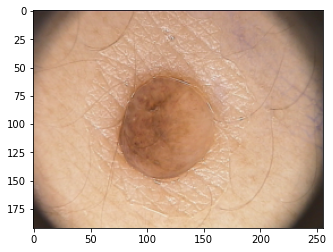

In [18]:
img = train_set[1][0].permute(1,2,0)
print(img.shape)
print(img)
plt.imshow(img)

torch.Size([192, 256, 1])
tensor([[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]])


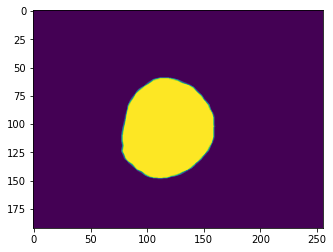

In [19]:
img = train_set[1][1].permute(1,2,0)
print(img.shape)
print(img)
plt.imshow(img)

## Model

In [44]:
class FrCN(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.backbone = models.vgg16(pretrained = True)
        
        self.block1 = nn.Sequential(*[self.backbone.features[i] for i in range(0,4)])
        self.block2 = nn.Sequential(*[self.backbone.features[i] for i in range(5,9)])
        self.block3 = nn.Sequential(*[self.backbone.features[i] for i in range(10,16)])
        self.block4 = nn.Sequential(*[self.backbone.features[i] for i in range(17,23)])
        self.block5 = nn.Sequential(*[self.backbone.features[i] for i in range(24,30)])
        self.block6 = nn.Sequential(
            nn.Conv2d(512, 4096, 7, padding=(1,1)),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Conv2d(4096, 4096, 1, padding=(1,1)),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Conv2d(4096, 1, 1, padding=(1,1)),
            nn.ReLU(),
        ) 
        
    def forward(self, x):
        
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        out = self.block6(x)

        return out

In [45]:
train_loader = DataLoader(train_set, batch_size=config["batch_size"], shuffle=True, num_workers=0, pin_memory=True)
valid_loader = DataLoader(valid_set, batch_size=config["batch_size"], shuffle=True, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=config["batch_size"], shuffle=True, num_workers=0, pin_memory=True)

In [46]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = FrCN().to(device)
# BCEwithlogitsloss = BCELoss + Sigmoid
loss_func = nn.BCEWithLogitsLoss()

# optimizer = torch.optim.Adadelta(model.parameters())
# optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

train_steps = len(train_set) / config["batch_size"]
valid_steps = len(valid_set) / config["batch_size"]
test_steps = len(valid_set) / config["batch_size"]

In [47]:
print("Training the network...")

best_loss = float("inf")
train_loss_history = []
train_iou_history = []
valid_loss_history = []
valid_iou_history = []

for epoch in range(config["n_epochs"]):
    
    model.train()
    
    total_train_loss = 0
    total_train_iou = 0
    total_valid_loss = 0
    total_valid_iou = 0
    
    for (i, (x, y)) in enumerate(tqdm(train_loader)):
      
        (x, y) = (x.to(device), y.to(device))
    
        logits = model(x)
        pred = torch.sigmoid(logits)
        loss = loss_func(logits, y)
        iou = jaccard_index(pred, y.type(torch.int8), num_classes=2)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
       
        total_train_loss += loss
        total_train_iou += iou
         
    train_loss = total_train_loss / train_steps
    train_loss_history.append(train_loss.cpu().detach().numpy())
    train_iou = total_train_iou / train_steps
    train_iou_history.append(train_iou.cpu().detach().numpy())
    print(f'[ Train | {epoch + 1:03d}/{config["n_epochs"]:03d} ] loss = {train_loss:.5f} iou = {train_iou:.5f}')
    
    
    with torch.no_grad():
       
        model.eval()
        
        for (x, y) in tqdm(valid_loader):
           
            (x, y) = (x.to(device), y.to(device))
     
            logits = model(x)
            pred = torch.sigmoid(logits)
            loss = loss_func(logits, y)
            iou = jaccard_index(pred, y.type(torch.int8), num_classes=2)

            total_valid_loss += loss
            total_valid_iou += iou
            
        
    
    valid_loss = total_valid_loss / valid_steps
    valid_loss_history.append(valid_loss.cpu().detach().numpy())
    valid_iou = total_valid_iou / valid_steps
    valid_iou_history.append(valid_iou.cpu().detach().numpy())
    print(f'[ Valid | {epoch + 1:03d}/{config["n_epochs"]:03d} ] loss = {valid_loss:.5f} iou = {valid_iou:.5f}')
    
    # save models
    if valid_loss < best_loss:
        print(f"Best model found at epoch {epoch}, saving model")
        
        torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                # 'scheduler': scheduler.state_dict(),
                }, f'{config["model"]}_best.ckpt')

        best_loss = valid_loss

Training the network...


  0%|          | 0/160 [00:00<?, ?it/s]

torch.Size([1, 512, 6, 8])


ValueError: Target size (torch.Size([1, 1, 192, 256])) must be the same as input size (torch.Size([1, 1, 6, 8]))

In [ ]:
plt.figure()
plt.plot(train_loss_history, label="Train")
plt.plot(valid_loss_history, label="Valid")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.show()

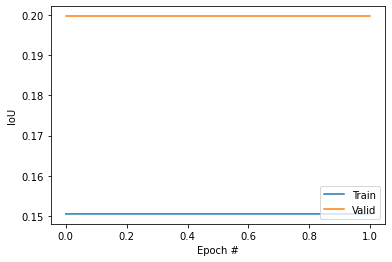

In [36]:
plt.figure()
plt.plot(train_iou_history, label="Train")
plt.plot(valid_iou_history, label="Valid")
plt.xlabel("Epoch #")
plt.ylabel("IoU")
plt.legend(loc="lower right")
plt.show()

## Prediction

In [37]:
model_best = FrCN().to(device)
checkpoint = torch.load(f'{config["model"]}_best.ckpt')
model_best.load_state_dict(checkpoint["model_state_dict"])
model_best.eval()
total_test_iou = 0
for (x, y) in tqdm(test_loader):
    (x, y) = (x.to(device), y.to(device))
    logits = model_best(x)
    pred = torch.sigmoid(logits)
    iou = jaccard_index(pred, y.type(torch.int8), num_classes=2)
    total_test_iou += iou
    
test_iou = total_test_iou / test_steps
print("Test IoU:", test_iou)

100%|██████████| 20/20 [00:08<00:00,  2.36it/s]

Test IoU: tensor(0.1670, device='cuda:0')


In [38]:
def visualization(originImage, originMask, predMask, iou):
    figure, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))
    
    ax[0].imshow(originImage)
    ax[1].imshow(originMask)
    ax[2].imshow(predMask)
   
    ax[0].set_title("Image")
    ax[1].set_title("Original Mask")
    ax[2].set_title("Predicted Mask")
    t = ax[2].text(170, 20, f'IoU = {iou:.3f}')
    t.set_bbox(dict(facecolor='white', alpha=0.75, edgecolor='white'))
    
    figure.tight_layout()
    figure.show()

In [ ]:
threshold = 0.5
fig = plt.figure(figsize=(10, 8))
outer = gridspec.GridSpec(4, 1, wspace=0.2, hspace=0.2)

for i in range(4):
    img, mask = test_set[i]
    (img, mask) = (img.to(device), mask.to(device))

    logits = model_best(img.unsqueeze(0))
    pred = torch.sigmoid(logits)
    iou = jaccard_index(pred, mask.type(torch.int8), num_classes=2)
    pred_mask = (pred > threshold).float()*1

    origin_img = img.permute(1,2,0).cpu().detach().numpy()
    origin_mask = mask.permute(1,2,0).cpu().detach().numpy()
    pred_mask = pred_mask.squeeze(0).permute(1,2,0).cpu().detach().numpy()
    
    
    inner = gridspec.GridSpecFromSubplotSpec(1, 3,
                    subplot_spec=outer[i], wspace=0.1, hspace=0.1)
    
    visualization(origin_img, origin_mask, pred_mask, iou)